# Finding Available Rates

The {py:obj}`Library <pynucastro.rates.library.Library>` class provides a high level interface for reading files containing one or more Reaclib rates and then filtering these rates based on user-specified criteria for the nuclei involved in the reactions. We can then use the resulting rates to build a network.

## Searching all rates

We can get a single library with all the rates known to pynucastro---this is a combination of {py:obj}`ReacLibLibrary <pynucastro.rates.library.ReacLibLibrary>`, all of the different collections that can be part of {py:obj}`TabularLibrary <pynucastro.rates.library.TabularLibrary>`, and the rates contained in {py:mod}`alternate_rates <pynucastro.rates.alternate_rates>`.  This is done via {py:meth}`full_library <pynucastro.rates.library.full_library>`.

In [1]:
import pynucastro as pyna

In [2]:
lib = pyna.full_library()

```{note}
The {py:obj}`Library <pynucastro.rates.library.Library>` returned by `full_library` will have duplicates for some links, since multiple sources can provide a rate.
```

We can see the total number of rates

In [3]:
lib.num_rates

82491

## Getting a rate by name

The {py:obj}`get_rate_by_name <pynucastro.rates.library.Library.get_rate_by_name>` function
can be used on any `Library` object.

Here we get ${}^{12}\mathrm{C}(\alpha, \gamma){}^{16}\mathrm{O}$: 

In [4]:
c12ag = lib.get_rate_by_name("c12(a,g)o16")
c12ag

[C12 + He4 ⟶ O16 + 𝛾, C12 + He4 ⟶ O16 + 𝛾]

Here we see that we pick up two rates---these are from different sources:

In [5]:
for r in c12ag:
    print(f"{str(r):24} {r.source['Label']:6}  {type(r).__name__}")

C12 + He4 ⟶ O16 + 𝛾      nac2    ReacLibRate
C12 + He4 ⟶ O16 + 𝛾      debo    DeBoerC12agO16


The first is from ReacLib and the second is a more recent rate from {cite:t}`deboer:2017`.

## Using filters

We can then use a {py:obj}`RateFilter <pynucastro.rates.library.RateFilter>` to find rates.

For example, to find all the rates that involve ${}^{56}\mathrm{Ni}$ as a reactant, we can do:

In [6]:
rf = pyna.RateFilter(reactants=["ni56"], exact=False)
new_lib = lib.filter(rf)
rates = new_lib.get_rates()

In [7]:
for r in sorted(rates):
    print(f"{str(r):24} {r.source['Label']:10}  {type(r).__name__}")

Ni56 + e⁻ ⟶ Co56 + 𝜈     ffn         TabularRate
Ni56 + e⁻ ⟶ Co56 + 𝜈     langanke    TabularRate
Ni56 + n ⟶ He4 + Fe53    ths8        ReacLibRate
Ni56 + n ⟶ p + Co56      ths8        ReacLibRate
Ni56 + n ⟶ Ni57 + 𝛾      ths8        ReacLibRate
Ni56 + p ⟶ He4 + Co53    ths8        ReacLibRate
Ni56 + p ⟶ n + Cu56      ths8        ReacLibRate
Ni56 + p ⟶ Cu57 + 𝛾      wien        ReacLibRate
Ni56 + He4 ⟶ p + Cu59    ths8        ReacLibRate
Ni56 + He4 ⟶ n + Zn59    ths8        ReacLibRate
Ni56 + He4 ⟶ Zn60 + 𝛾    ths8        ReacLibRate
Ni56 ⟶ He4 + Fe52        ths8        ReacLibRate
Ni56 ⟶ p + Co55          ths8        ReacLibRate
Ni56 ⟶ Co56 + e⁺ + 𝜈     wc12        ReacLibRate
Ni56 ⟶ n + Ni55          ths8        ReacLibRate


Now we see that there are three electron capture / $\beta^+$ rates:
* a tabular version from {cite:t}`ffn`
* a tabular version from {cite:t}`langanke:2001`
* a simple decay constant from ReacLib

For a network, we would only use one on these.  In fact, we will raise an exception if we try to use them all:

In [8]:
net = pyna.RateCollection(libraries=[new_lib])

[[Ni56 ⟶ Co56 + e⁺ + 𝜈, Ni56 + e⁻ ⟶ Co56 + 𝜈, Ni56 + e⁻ ⟶ Co56 + 𝜈]]


RateDuplicationError: Duplicate rates found

```{tip}
This is one key difference between a `Library` and a network in pynucastro---a `Library` can have duplicate rates, and can be thought of as a container used in the process of selecting the rates that will finally be part of your network.
```

## Specifying desired nuclei

This example constructs a CNO network like the one constructed from a set of Reaclib rate files in the *pynucastro usage examples* section of this documentation.

This time, however, we will specify the nuclei we want in the network and allow the `Library` class to find all the rates linking only nuclei in the set we specified.

We can specify these nuclei by their abbreviations in the form, e.g. "he4":

In [9]:
all_nuclei = ["p", "he4", "c12", "n13", "c13", "o14", "n14", "o15", "n15"]

Now we use the {py:obj}`Library.linking_nuclei <pynucastro.rates.library.Library.linking_nuclei>` function to return a smaller `Library` object containing only the rates that link these nuclei.

```{tip}
We can pass `with_reverse=False` to restrict `linking_nuclei` to only include forward rates from the Reaclib library.
```

In [11]:
rl = pyna.ReacLibLibrary()

In [12]:
cno_library = rl.linking_nuclei(all_nuclei, with_reverse=False)

Now we can create a network (here we'll do a {py:obj}`PythonNetwork <pynucastro.networks.python_network.PythonNetwork>`) as:

In [13]:
cno_network = pyna.PythonNetwork(libraries=cno_library)

```{note}
In the above, we construct a network by passing our `Library` object to the network constructor via the `libraries` keyword argument. To construct a network from multiple libraries, the `libraries` argument can also take a list of `Library` objects.
```

We can show the structure of the network by plotting a network diagram.

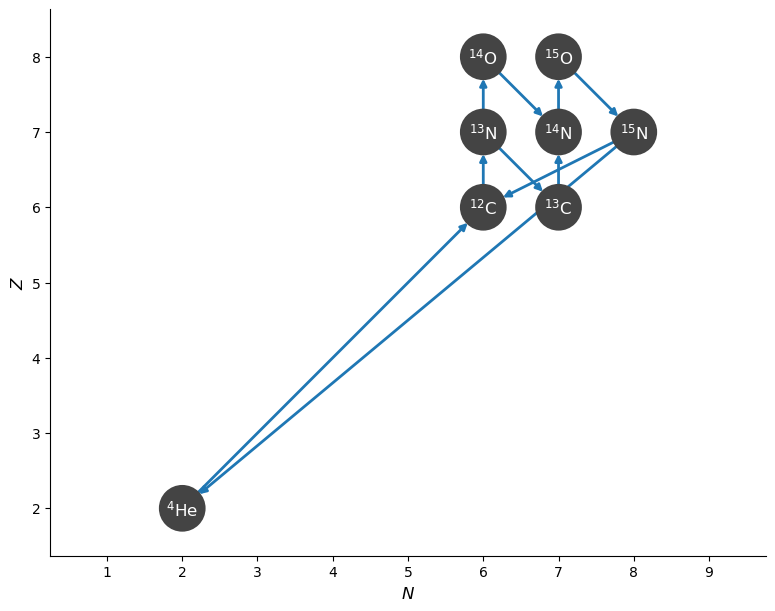

In [15]:
fig = cno_network.plot()

```{note}
This network includes the 3-$\alpha$ rate from ReacLib---this probably isn't needed for CNO burning, so we could have removed it from the library before making the network.
```

## Exact filtering

Exact filtering is useful when you have a specific rate in mind or a specific combination of reactants or products. In the following example, we look for all rates of the form $\mathrm{^{12}C + ^{12}C \rightarrow \ldots}$

To use exact filtering, omit the `exact` keyword to the `RateFilter` constructor, as it is turned on by default.

```{note}
Exact filtering does not mean all the nuclei involved in the rate must be specified, it means that all filtering options passed to the `RateFilter` constructor are strictly applied. In this case, the filter will return rates with exactly two reactants, both of which are $\mathrm{^{12}C}$. However, the filter places no constraint on the products or number of products in the rate.
```

In [17]:
c12_exact_filter = pyna.rates.RateFilter(reactants=['c12', 'c12'])
c12_exact_library = lib.filter(c12_exact_filter)
print(c12_exact_library)

C12 + C12 ⟶ He4 + Ne20         [Q =   4.62 MeV] (C12 + C12 --> He4 + Ne20 <cf88_reaclib__>)
C12 + C12 ⟶ p + Na23           [Q =   2.24 MeV] (C12 + C12 --> p + Na23 <cf88_reaclib__>)
C12 + C12 ⟶ n + Mg23           [Q =  -2.60 MeV] (C12 + C12 --> n + Mg23 <cf88_reaclib__derived_from_inverse>)


## Example: building an $\alpha$-capture network

In the next example, we use rate filtering to iteratively construct a `Library` containing the alpha capture rates linking $\mathrm{^{12}C}$ to $\mathrm{^{56}Ni}$.

We use the following procedure:

* Start with a seed nucleus, $\mathrm{^{12}C}$
* Loop
  * Find the rates that are $\alpha$-capture on the current nucleus
  * Use {py:obj}`Library.heaviest <pynucastro.rates.library.Library.heaviest>` to find the heaviest nucleus in the filtered rates. This corresponds to the nucleus with the largest mass number, and in case of a tie between isobars, this returns the isobar with the smallest atomic number.
  * Find the reverse rate using the heaviest nucleus
  * If the mass number of the heaviest nucleus is less that 56, set the seed to the current heaviest nuclei

```{note}
In the example below, we add each filtered library to our alpha capture library `alpha_library`, initialized as an empty `Library`. The `Library` class supports the addition operator by returning a new library containing the rates in the two libraries we added together.
```

This example also introduces the `max_products` keyword, which specifies we are looking for reactions producing at most `max_products` product nuclei.

Similarly, the `RateFilter` constructor supports the following keywords constraining the number of reactants and products:

* `min_reactants`
* `max_reactants`
* `min_products`
* `max_products`

```{note}
Because we have omitted the argument `exact=False`, the filter constraints we apply are exact.
```

In [19]:
alpha_library = pyna.Library()

capture = pyna.Nucleus('he4')
seed = pyna.Nucleus('c12')

while True:
    ac_filter = pyna.RateFilter(reactants=[capture, seed], max_products=1)
    ac_library = rl.filter(ac_filter)
    alpha_library = alpha_library + ac_library

    heavy = ac_library.heaviest()
    ac_filter_inv = pyna.RateFilter(reactants=[heavy], products=[capture, seed])
    ac_inv_library = rl.filter(ac_filter_inv)
    alpha_library = alpha_library + ac_inv_library

    print(heavy)
    if heavy.A == 56:
        break
    else:
        seed = heavy

O16
Ne20
Mg24
Si28
S32
Ar36
Ca40
Ti44
Cr48
Fe52
Ni56


We will next print out the library we constructed, seeing that we have both forward and reverse rates for the alpha chain.

Note that in this example, we are just using the reverse rates provided by ReacLib and not rederiving
them via detailed balance together with the nuclear partition function.  This can be done using the {py:obj}`DerivedRate <pynucastro.rates.derived_rate.DerivedRate>` class.

In [20]:
alpha_library

C12 + He4 ⟶ O16 + 𝛾            [Q =   7.16 MeV] (C12 + He4 --> O16 <nac2_reaclib__>)
O16 + He4 ⟶ Ne20 + 𝛾           [Q =   4.73 MeV] (O16 + He4 --> Ne20 <co10_reaclib__>)
Ne20 + He4 ⟶ Mg24 + 𝛾          [Q =   9.32 MeV] (Ne20 + He4 --> Mg24 <il10_reaclib__>)
Mg24 + He4 ⟶ Si28 + 𝛾          [Q =   9.98 MeV] (Mg24 + He4 --> Si28 <st08_reaclib__>)
Si28 + He4 ⟶ S32 + 𝛾           [Q =   6.95 MeV] (Si28 + He4 --> S32 <ths8_reaclib__>)
S32 + He4 ⟶ Ar36 + 𝛾           [Q =   6.64 MeV] (S32 + He4 --> Ar36 <ths8_reaclib__>)
Ar36 + He4 ⟶ Ca40 + 𝛾          [Q =   7.04 MeV] (Ar36 + He4 --> Ca40 <ths8_reaclib__>)
Ca40 + He4 ⟶ Ti44 + 𝛾          [Q =   5.13 MeV] (Ca40 + He4 --> Ti44 <chw0_reaclib__>)
Ti44 + He4 ⟶ Cr48 + 𝛾          [Q =   7.70 MeV] (Ti44 + He4 --> Cr48 <ths8_reaclib__>)
Cr48 + He4 ⟶ Fe52 + 𝛾          [Q =   7.94 MeV] (Cr48 + He4 --> Fe52 <ths8_reaclib__>)
Fe52 + He4 ⟶ Ni56 + 𝛾          [Q =   8.00 MeV] (Fe52 + He4 --> Ni56 <ths8_reaclib__>)
O16 ⟶ He4 + C12                [Q =  -7.16 MeV] 

Next we can create a reaction network from our filtered alpha capture library by passing our library to a network constructor using the `libraries` keyword.

In [21]:
alpha_network = pyna.PythonNetwork(libraries=alpha_library)

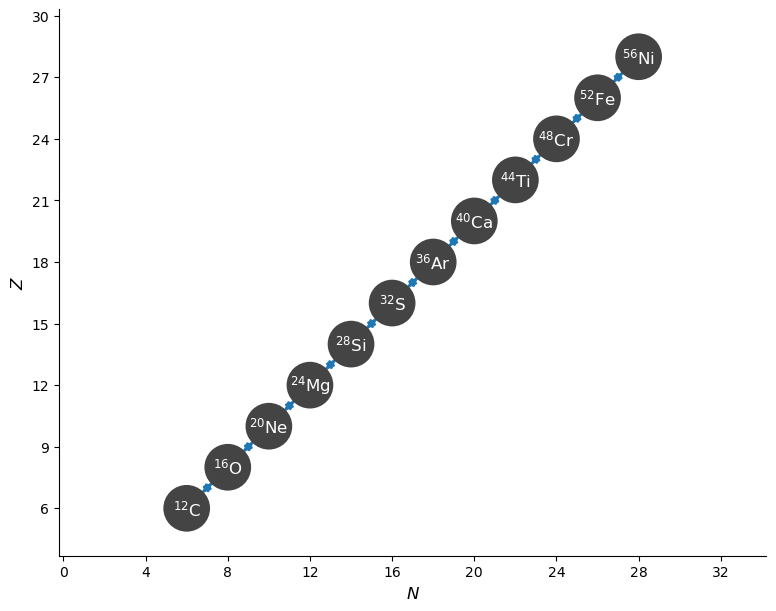

In [22]:
fig = alpha_network.plot()

```{warning}
This is not a realistic network for science applications, because the $(\alpha, p)(p, \gamma)$ links between the 
nuclei are also important.  We'll discuss adding them (and approximating them) later.
```